In [4]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import PreTrainedTokenizerFast
from eval import evaluate_generated_sequences
from model import TwoLayer, FourLayer, SixLayer, GPT

def plot_results(results_log, model_name):

    for pcfg_name, ckpt_dict in results_log.items():
        # collect (epoch, accuracy) pairs
        epoch_acc = []
        for ckpt_file, data in ckpt_dict.items():
            try:
                # assumes your checkpoints are named like "checkpoint_epoch_10.pt"
                epoch = int(os.path.splitext(ckpt_file)[0].split("_")[-1])
            except ValueError:
                continue
            epoch_acc.append((epoch, data["accuracy"]))

        epoch_acc.sort(key=lambda x: x[0])
        epochs, accuracies = zip(*epoch_acc)

        # plot this grammar’s curve
        plt.plot(epochs, accuracies, marker='o', label=pcfg_name)

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy over Epochs for {model_name}")
    plt.grid(True)
    plt.legend(title="Grammar")
    plt.tight_layout()

    plt.savefig(f"../results/accuracy_plot_{model_name}.png")
    plt.show()
    plt.close()

def plot_avg_length(results_log, model_name):
    for pcfg_name, ckpt_dict in results_log.items():
        epoch_len = []
        for ckpt_file, data in ckpt_dict.items():
            # parse epoch from filename, e.g. "checkpoint_10.pt" → 10
            try:
                epoch = int(os.path.splitext(ckpt_file)[0].split("_")[-1])
            except ValueError:
                continue

            seqs = data.get("generated_sequences", [])

            # assume each seq is a whitespace‐joined string of tokens
            lengths = [
                len(s.split()) if isinstance(s, str) and s.strip() != "" else 0
                for s in seqs
            ]
            avg_len = float(np.mean(lengths))
            epoch_len.append((epoch, avg_len))

        # sort by epoch
        epoch_len.sort(key=lambda x: x[0])
        epochs, avg_lengths = zip(*epoch_len)

        # plot
        plt.plot(epochs, avg_lengths, marker='o', label=pcfg_name)

    plt.xlabel("Epoch")
    plt.ylabel("Average Generated Sequence Length")
    plt.title(f"Average Generated Sequence Length over Epochs ({model_name})")
    plt.grid(True)
    plt.legend(title="Grammar")
    plt.tight_layout()

    plt.show()
    plt.close()


def analyze(pcfgs, dataset_size, model_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results_log = {}
    model = GPT(model_config).to(device)

    seed = 42
    torch.manual_seed(seed)

    for pcfg in pcfgs:
        main_path = os.path.join('../data', pcfg, pcfg + "_" + dataset_size)
        with open(f"{main_path}/train.jsonl", 'r') as f:
            training_sequences = [json.loads(line)["sequence"] for line in f]

        with open(f"{main_path}/test.jsonl", 'r') as f:
            test_sequences = [json.loads(line)["sequence"] for line in f]

        tokenizer = PreTrainedTokenizerFast(
            tokenizer_file=f"{main_path}/tokenizer.json",
            bos_token="<|bos|>",
            eos_token="<|eos|>"
        )

        checkpoints_dir = os.path.join(main_path, model_config.name)
        results_log[pcfg] = {}

        for ckpt in sorted(os.listdir(checkpoints_dir)):
            if ckpt.endswith(".pt"):
                model.load_state_dict(torch.load(os.path.join(checkpoints_dir, ckpt), map_location=device))
                generated_sequences, accuracy, train_overlap, res = evaluate_generated_sequences(
                    model,
                    tokenizer,
                    training_sequences,
                    pcfg,
                    test_sequences,
                    device,
                    num_samples=50,
                    max_length=256
                )
                results_log[pcfg][ckpt] = {
                    "generated_sequences": generated_sequences,
                    "accuracy": accuracy,
                    "train_overlap": train_overlap,
                    "res": res
                }
    
    results_path = os.path.join("../results", "results_log.json")

    # Load existing results if file exists
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            existing_results = json.load(f)
    else:
        existing_results = {}

    # Append new results
    existing_results.update(results_log)

    # Save updated results
    with open(results_path, 'w') as f:
        json.dump(existing_results, f)

    plot_results(results_log, model_config.name)

number of parameters: 19.18M
[VALIDATION ERROR - ArithmeticLogic] ['val', 'else', 'val', 'else', 'if', 'cond', 'then', 'val', ')', 'val', ')', 'else', '(', 'val', '+', '(', '(', 'val', 'else', 'val', ')', 'else', 'val', 'else', 'if', 'not', 'cond', 'and', 'cond', 'then', 'if', 'not', 'cond', 'then', 'val', '*', 'val', ')', '+', '(', 'if', 'cond', 'then', 'val', '+', 'val', 'else', 'val', 'else', 'val', ')', 'else', '(', 'val', 'else', 'val', '*', 'if', 'cond', 'then', 'val', 'else', 'val', 'else', 'val', 'else', 'if', 'cond', 'then', '(', 'if', 'not', 'cond', 'then', 'if', 'cond', 'then', 'if', 'not', 'cond', 'and', 'cond', 'then', 'val', '+', 'if', 'cond', 'then', '(', '(', 'if', 'not', 'cond', 'then', '(', '(', 'if', 'not', 'cond', 'and', 'cond', 'then', 'if', 'not', 'not', 'cond', 'then', 'if', 'cond', 'then', 'val', 'else', 'if', 'cond', 'and', 'not', 'cond', 'and', 'not', 'not', 'not', 'cond', 'then', '(', 'val', 'else', 'val', ')', '*', 'if', 'cond', 'and', 'cond', 'then', 'if', 

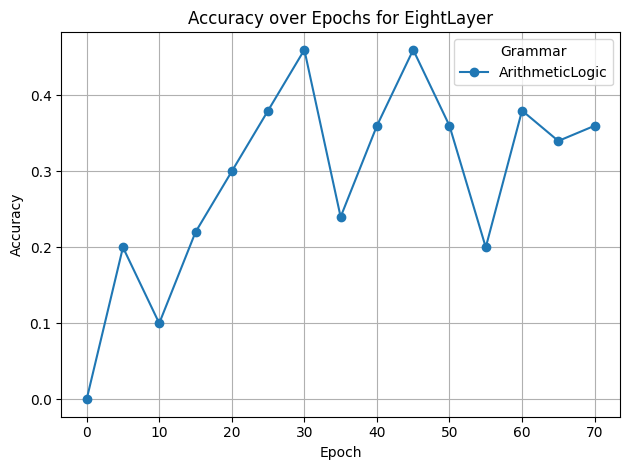

In [2]:
pcfgs = ["ArithmeticLogic"]
dataset_size = '1000'
model_config = SixLayer()
analyze(pcfgs, dataset_size, model_config)

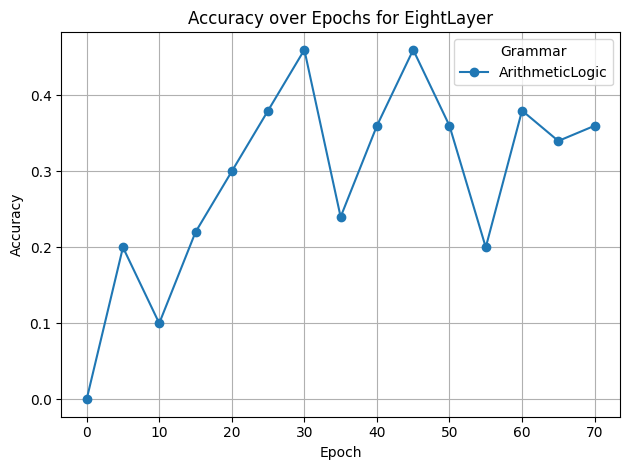

In [5]:
with open("../results/results_log.json", "r") as f:
    results_log = json.load(f)
plot_results(results_log, model_config.name)

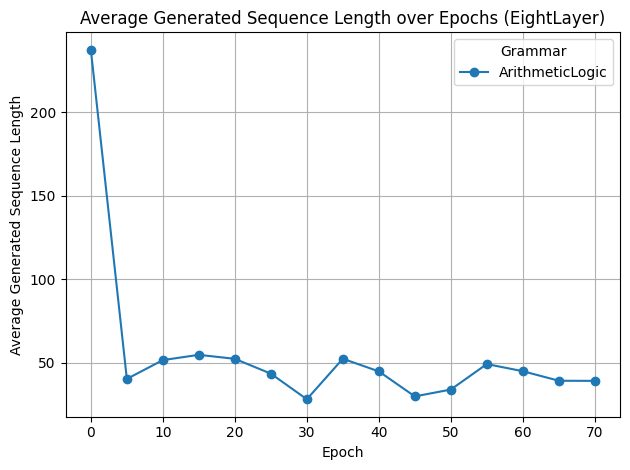

In [3]:
with open("../results/results_log.json", "r") as f:
    results_log = json.load(f)
plot_avg_length(results_log, model_config.name)